In [1]:
from matplotlib import pyplot as plt
from utils_Function import *
from utils_Optimizer import *
import seaborn as sn
import numpy as np

In [2]:
root = r"data/CarTruck/"
train_x_orig, train_y = load_data(root=root, set_type="Train")
valid_x_orig, valid_y = load_data(root=root, set_type="Valid")
test_x_orig, test_y = load_data(root=root, set_type="Test")

In [3]:
print(train_x_orig.shape)
print(train_y.shape)

(977, 64, 64, 3)
(1, 977)


0


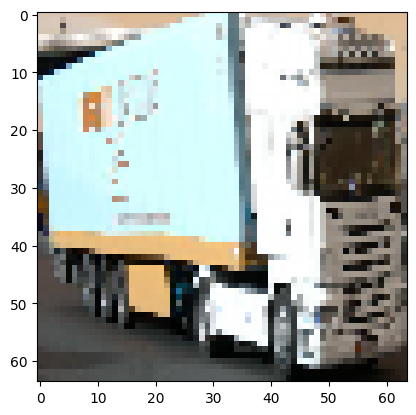

In [4]:
i = 17
print(train_y[0][i])
plt.imshow(train_x_orig[i])

In [5]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   
valid_x_flatten = valid_x_orig.reshape(valid_x_orig.shape[0], -1).T   
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255
valid_x = valid_x_flatten/255
test_x = test_x_flatten/255

print ("train_x's shape: " + str(train_x.shape))
print ("valid_x's shape: " + str(valid_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 977)
valid_x's shape: (12288, 194)
test_x's shape: (12288, 96)


In [18]:
layers_dims = [train_x.shape[0], 128, 32, 8, 1] 
keep_probs = [0.7, 0.8, 0.87, 0.9]

In [21]:
def L_layer_model(X_train, Y_train, X_valid, Y_valid, 
                  layers_dims, 
                  lambd=0.7, 
                  drop_out=True, 
                  keep_probs=keep_probs, 
                  learning_rate = 0.0075, 
                  mini_batch_size=128, 
                  beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, 
                  num_iterations = 3000, 
                  print_cost=False):

    costs_train = []       
    costs_valid = []                 
    t = 0
    parameters = initialize_parameters_deep(layers_dims)
    
    v, s = initialize_adam(parameters)
 
    for i in range(0, num_iterations):
        
        minibatches_train = random_mini_batches(X_train, Y_train, mini_batch_size)
        for minibatch in minibatches_train:
            
            (minibatch_X, minibatch_Y) = minibatch

            AL_train, caches = L_model_forward(minibatch_X, parameters, keep_probs=keep_probs, drop_out=drop_out)
            cost_train = compute_cost(AL_train, minibatch_Y, parameters, lambd)
            
            AL_valid, _ = L_model_forward(X_valid, parameters, keep_probs=keep_probs, drop_out=False)
            cost_valid = compute_cost(AL_valid, Y_valid, parameters, lambd)

            grads = L_model_backward(AL_train, minibatch_Y, caches, lambd, drop_out=drop_out)

            t = t + 1 
            parameters, v, s = update_parameters_with_adam(parameters, 
                                                           grads, 
                                                           v, s,
                                                           t, 
                                                           learning_rate, 
                                                           beta1, beta2, epsilon)

        if print_cost and i % 10 == 0:
            print("Train_cost after iteration %i: %f" %(i, cost_train))
            print("Valid_cost after iteration %i: %f" %(i, cost_valid))
            print("---------------------------------------------")
        if print_cost and i % 10 == 0:
            costs_train.append(cost_train)
            costs_valid.append(cost_valid)
            
    plt.plot(np.squeeze(costs_train), color='blue', label='Train_cost')
    plt.plot(np.squeeze(costs_valid), color='orange', label='Val_cost')
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.legend(loc='lower left', shadow=True)
    plt.show()
    
    return parameters

Train_cost after iteration 0: 1.284304
Valid_cost after iteration 0: 0.940324
---------------------------------------------
Train_cost after iteration 10: 0.716828
Valid_cost after iteration 10: 0.679605
---------------------------------------------
Train_cost after iteration 20: 0.671511
Valid_cost after iteration 20: 0.660290
---------------------------------------------
Train_cost after iteration 30: 0.520531
Valid_cost after iteration 30: 0.645075
---------------------------------------------
Train_cost after iteration 40: 0.456429
Valid_cost after iteration 40: 0.657106
---------------------------------------------
Train_cost after iteration 50: 0.563714
Valid_cost after iteration 50: 0.678769
---------------------------------------------
Train_cost after iteration 60: 0.461985
Valid_cost after iteration 60: 0.661116
---------------------------------------------
Train_cost after iteration 70: 0.570164
Valid_cost after iteration 70: 0.731058
----------------------------------------

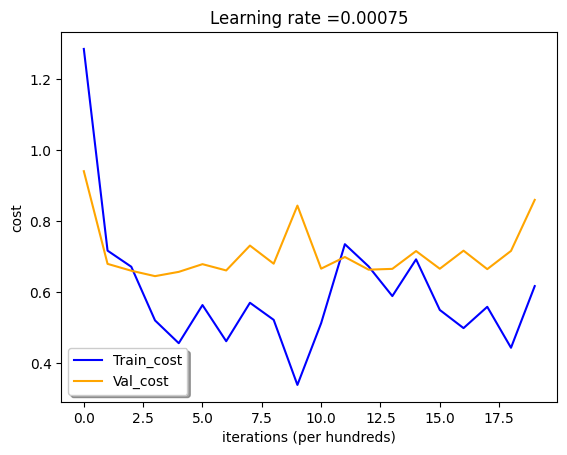

In [22]:
parameters = L_layer_model(train_x, train_y, valid_x, valid_y, 
                           layers_dims,  
                           num_iterations = 200, 
                           print_cost = True)

In [23]:
y_pred = predict(test_x, test_y, parameters)

Accuracy: 0.6875


In [24]:
class evaluate():
    def __init__(self, predict, real):
        self.predict = predict
        self.real = real

        # Positive = 1, Negative = 0
        # True Positive: predict = real = Possitive(1)
        self.TP = ((self.predict*self.real) == 1).sum()
        # False Negative: predict = Negative(0) but real = Positive(1)
        self.FN = ((self.real - self.predict) == 1).sum()
        # False Positive: predict = Positive(1) but real = Negative(0)
        self.FP = ((self.predict - self.real) == 1).sum()
        # True Negative: predict = real = Negative(0) 
        self.TN = ((self.predict + self.real) == 0).sum()
    
    def plot_confusion_matrix(self):
        confusion_matrix = np.array([[self.TP, self.FN], [self.FP, self.TN]])
        sn.heatmap(confusion_matrix, annot =True)
        plt.xlabel("Predict")
        plt.ylabel("Actual")
        

    def Accuracy(self):
        # accuracy = True / Total 
        return (self.TP + self.TN)/(self.TP + self.FN + self.FP + self.TN)

    def Precision(self):
        # trong số những dữ liệu dự đoán là positive có bao nhiêu cái là đúng
        return self.TP / (self.TP + self.FP)

    def Recall(self):
        # trong số những dữ liệu thực sự là positive dự đoán đúng bao nhiêu
        return self.TP / (self.TP + self.FN)

    def F1_Score(self):
        return (2*self.TP) / (2*self.TP + self.FP + self.FN)

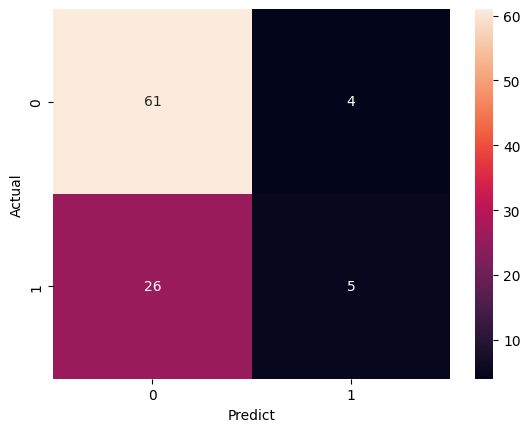

In [25]:
check = evaluate(y_pred, test_y)
check.plot_confusion_matrix()

In [26]:
print("Accuracy",check.Accuracy())
print("Precision",check.Precision())
print("Recall",check.Recall())
print("F1_Score",check.F1_Score())

Accuracy 0.6875
Precision 0.7011494252873564
Recall 0.9384615384615385
F1_Score 0.8026315789473685


In [30]:
def plot_results(imgs, label, n_rows=10, n_cols=9, fig_size=10, img_dim=28):
    f, axarr = plt.subplots(n_rows, n_cols, figsize=(fig_size, fig_size))
    for i, ax in enumerate(axarr.flat):
        ax.imshow(imgs[i])
        ax.axis('off')  
        ax.title.set_text("Truck" if(label[i] == 0) else "Car")
    plt.show()

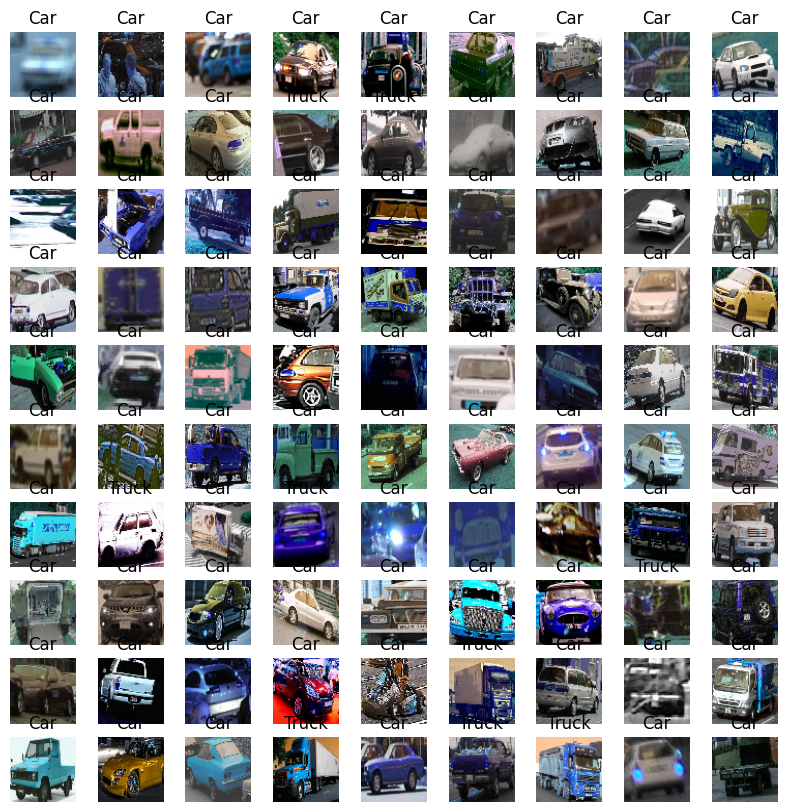

In [31]:
plot_results(test_x_orig, y_pred[0])